# Notebook 3: Modelltraining & Evaluation mit Linearer Regression und Random Forest

Die vorbereiteten Features werden geladen, in Trainings- und Test-Sets aufgeteilt und zwei Modelle – ein linearer Regressor sowie ein Random Forest Regressor – trainiert, evaluiert und verglichen. Anschliessend werden die Hyperparameter des besten Modells via GridSearchCV optimiert, das finale Modell als .pkl-Datei gespeichert und für die Veröffentlichung auf Huggingface vorbereitet.

## 1. Setup & Laden der Daten  
Importieren aller benötigten Bibliotheken und Einlesen der finalen Feature-Matrix inklusive der Zielvariable `sellingprice`.

In [7]:
# 1.1 Imports
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib

# 1.2 Pfad zur finalen Feature-Matrix
DATA_PATH = "../data/processed/cars_features_ready.csv"

# 1.3 Einlesen des Datensatzes
cars_features_df = pd.read_csv(DATA_PATH)

# 1.4 Kurzer Datenüberblick
cars_features_df.head()


,year,condition,odometer,mmr,sale_year,sale_month,sale_day,sale_weekday,body,transmission,...,season,has_sport,has_limited,has_lx,has_se,has_touring,has_premium,miles_per_year,color_popularity,sellingprice
0,2015,2.0,5559.0,15350.0,2015,1,13,1,Sedan,automatic,...,Winter,0,0,0,1,0,0,5559.0,4,12000.0
1,2012,35.0,45035.0,15450.0,2014,12,18,3,SUV,automatic,...,Winter,0,1,0,0,0,0,22517.5,3,14100.0
2,2012,46.0,20035.0,20700.0,2014,12,18,3,SUV,automatic,...,Winter,0,0,0,1,0,0,10017.5,3,20800.0
3,2012,46.0,41115.0,19800.0,2014,12,18,3,SUV,automatic,...,Winter,0,0,0,1,0,0,20557.5,4,22100.0
4,2012,3.0,26747.0,12900.0,2014,12,17,2,Hatchback,automatic,...,Winter,0,0,0,0,0,0,13373.5,6,14000.0


## 2. Datenüberblick & Beschreibung  
Kurzer Überblick über die geladenen Daten mittels `head()`, `info()` und `describe()`.

In [8]:
# 2.1 Erster Blick auf die Daten
cars_features_df.head()

# 2.2 Informationen zu Datentypen und fehlenden Werten
cars_features_df.info()

# 2.3 Statistische Kennzahlen der numerischen Features
cars_features_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98129 entries, 0 to 98128
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                98129 non-null  int64  
 1   condition           98129 non-null  float64
 2   odometer            98129 non-null  float64
 3   mmr                 98129 non-null  float64
 4   sale_year           98129 non-null  int64  
 5   sale_month          98129 non-null  int64  
 6   sale_day            98129 non-null  int64  
 7   sale_weekday        98129 non-null  int64  
 8   body                98129 non-null  object 
 9   transmission        98129 non-null  object 
 10  color               98129 non-null  object 
 11  interior            98129 non-null  object 
 12  avg_price_state     98129 non-null  float64
 13  median_price_state  98129 non-null  float64
 14  season              98129 non-null  object 
 15  has_sport           98129 non-null  int64  
 16  has_

,year,condition,odometer,mmr,sale_year,sale_month,sale_day,sale_weekday,avg_price_state,median_price_state,has_sport,has_limited,has_lx,has_se,has_touring,has_premium,miles_per_year,color_popularity,sellingprice
count,98129.000000,98129.000000,98129.000000,98129.000000,98129.000000,98129.000000,98129.000000,98129.000000,98129.000000,98129.000000,98129.000000,98129.000000,98129.000000,98129.000000,98129.000000,98129.000000,98129.000000,98129.000000,98129.000000
mean,2010.919402,31.659428,60446.622884,11858.851359,2014.875511,3.007592,15.194744,1.413466,11730.951085,11583.703085,0.012952,0.037573,0.065271,0.291331,0.005034,0.000245,17202.400363,3.936981,11730.951085
std,2.914241,12.489657,42732.015113,4959.365272,0.330140,3.518167,8.520374,1.221226,1213.626387,1330.645344,0.113069,0.190162,0.247005,0.454378,0.070774,0.015637,9377.824969,2.688439,4992.008021
min,1998.000000,1.000000,3346.000000,825.000000,2014.000000,1.000000,1.000000,0.000000,5775.000000,6150.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,728.363636,1.000000,2400.000000
25%,2010.000000,25.000000,28637.000000,8450.000000,2015.000000,1.000000,8.000000,1.000000,11165.785286,11100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10911.000000,2.000000,8200.000000
50%,2012.000000,35.000000,46245.000000,11900.000000,2015.000000,2.000000,16.000000,1.000000,11976.194837,12100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15068.000000,3.000000,11700.000000
75%,2013.000000,41.000000,85381.000000,14950.000000,2015.000000,2.000000,22.000000,2.000000,12301.101628,12400.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,21016.500000,5.000000,14900.000000
max,2015.000000,49.000000,221122.000000,39000.000000,2015.000000,12.000000,31.000000,6.000000,13687.691274,13400.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,121873.000000,20.000000,25000.000000


## Feature-Übersicht  
Tabellarische Übersicht aller Features mit kurzer Beschreibung.

| Feature                | Beschreibung                                                                                           |
|------------------------|--------------------------------------------------------------------------------------------------------|
| **year**               | Baujahr des Fahrzeugs                                                                                  |
| **condition**          | Zustandsbewertung (1 = schlecht bis 5 = ausgezeichnet)                                                 |
| **odometer**           | Laufleistung in Meilen                                                                                 |
| **mmr**                | Marktwert-Schätzung (Manheim Market Report)                                                            |
| **sale_year**          | Verkaufsjahr                                                                                           |
| **sale_month**         | Verkaufsmonat                                                                                          |
| **sale_day**           | Verkaufstag                                                                                            |
| **sale_weekday**       | Wochentag des Verkaufs (0 = Montag … 6 = Sonntag)                                                      |
| **body**               | Karosserieform (z. B. Sedan, SUV)                                                                      |
| **transmission**       | Getriebeart (z. B. Automatic, Manual)                                                                  |
| **color**              | Aussenfarbe                                                                                            |
| **interior**           | Innenausstattung                                                                                        |
| **avg_price_state**    | Durchschnittlicher Verkaufspreis im Bundesstaat                                                        |
| **median_price_state** | Medianer Verkaufspreis im Bundesstaat                                                                  |
| **season**             | Saison des Verkaufs (Winter, Spring, Summer, Fall)                                                     |
| **has_sport**          | Flag (0/1), ob “Sport” im Modell- oder Trim-Namen vorkommt                                             |
| **has_limited**        | Flag (0/1), ob “Limited” im Modell- oder Trim-Namen vorkommt                                           |
| **has_lx**             | Flag (0/1), ob “LX” im Modell- oder Trim-Namen vorkommt                                                |
| **has_se**             | Flag (0/1), ob “SE” im Modell- oder Trim-Namen vorkommt                                                |
| **has_touring**        | Flag (0/1), ob “Touring” im Modell- oder Trim-Namen vorkommt                                           |
| **has_premium**        | Flag (0/1), ob “Premium” im Modell- oder Trim-Namen vorkommt                                           |
| **miles_per_year**     | Jahresdurchschnitt der gefahrenen Meilen (odometer / (Verkaufsjahr – Baujahr))                         |
| **color_popularity**   | Rang der Lackfarbe nach Häufigkeit (1 = häufigste Farbe)                                               |
| **sellingprice**       | Tatsächlicher Verkaufspreis (Zielvariable)                                                             |

## 3. Datenvorverarbeitung  
Definition der Pipelines für numerische und kategoriale Features. Der `preprocessor` wird erst nach dem Train/Test-Split auf das Trainings-Set gefittet, um Data Leakage zu vermeiden.

In [9]:
# 3.1 Feature-Listen definieren
numeric_features = cars_features_df.select_dtypes(include=[np.number]).drop("sellingprice", axis=1).columns.tolist()
categorical_features = cars_features_df.select_dtypes(include=["object"]).columns.tolist()

# 3.2 Pipelines erstellen
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# 3.3 ColumnTransformer zur Anwendung beider Pipelines
preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_features),
    ("cat", categorical_pipeline, categorical_features)
])

# Hinweis: Nicht vor dem Split fitten!  
# Der Preprocessor wird in den Pipelines der Modell-Trainings- und CV-Schritte erst auf X_train gefittet.

## 4. Train-/Test-Split  
Definition von Merkmalen und Ziel sowie Aufteilung in Trainings- und Testset (80/20, `random_state=42`).

In [10]:
# 4.1 Merkmale (X) und Ziel (y) definieren
X = cars_features_df.drop("sellingprice", axis=1)
y = cars_features_df["sellingprice"]

# 4.2 Aufteilen in Trainings- und Testset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Ausgabe der Formen zur Kontrolle
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")


X_train: (78503, 23), X_test: (19626, 23)
y_train: (78503,), y_test: (19626,)


## 5. Modelldefinition  
Instanziieren der beiden Regressionsmodelle für den anschließenden Vergleich.

In [11]:
# 5.1 Modelle definieren
lr = LinearRegression()
rf = RandomForestRegressor(random_state=42)

## 6. Cross-Validation  
Durchführung einer 5-fach-Kreuzvalidierung auf dem gesamten Trainings-Set für beide Modelle (Linear Regression und Random Forest) ohne Stichprobe oder Parameterreduktion.

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

# 1) Preprocessing einmalig auf Trainingsdaten
X = preprocessor.fit_transform(X_train)
y = y_train.values

# 2) Linear Regression
lr = LinearRegression()
scores_lr = cross_val_score(
    lr,
    X,
    y,
    cv=5,
    scoring="neg_root_mean_squared_error"
)
print(f"Cross-validation RMSE (LR): {np.mean(-scores_lr):.2f}")

# 3) Random Forest
rf = RandomForestRegressor(random_state=42)
scores_rf = cross_val_score(
    rf,
    X,
    y,
    cv=5,
    scoring="neg_root_mean_squared_error"
)
print(f"Cross-validation RMSE (RF): {np.mean(-scores_rf):.2f}")



Cross-validation RMSE (LR): 1302.95
Cross-validation RMSE (RF): 1128.85


## 7. Modelltraining & Auswertung  
Beide Modelle werden auf dem gesamten Trainings-Set trainiert. Anschliessend werden Vorhersagen auf Trainings- und Test-Set berechnet und MAE, RMSE sowie R² verglichen, um Over- oder Underfitting zu identifizieren.

### 7.1 Modelltraining & Auswertung: Linear Regression  
Trainieren des linearen Regressors auf dem Trainings-Set und Berechnung von MAE, RMSE und R² für Trainings- und Test-Set.

In [13]:
# 7.1 Linear Regression

# 7.1.0 Hilfsfunktion korrigiert (RMSE manuell berechnen)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def calc_metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    return mae, rmse, r2

# 7.1.1 Pipeline erstellen
pipe_lr = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

# 7.1.2 Modell auf Trainingsdaten trainieren
pipe_lr.fit(X_train, y_train)

# 7.1.3 Vorhersagen für Trainings- und Test-Set
y_pred_train_lr = pipe_lr.predict(X_train)
y_pred_test_lr  = pipe_lr.predict(X_test)

# 7.1.4 Metriken berechnen
mae_train_lr, rmse_train_lr, r2_train_lr = calc_metrics(y_train, y_pred_train_lr)
mae_test_lr,  rmse_test_lr,  r2_test_lr  = calc_metrics(y_test,  y_pred_test_lr)

# 7.1.5 Ergebnisse ausgeben
print(f"LR Train: MAE={mae_train_lr:.2f}, RMSE={rmse_train_lr:.2f}, R2={r2_train_lr:.4f}")
print(f"LR Test:  MAE={mae_test_lr:.2f}, RMSE={rmse_test_lr:.2f}, R2={r2_test_lr:.4f}")


LR Train: MAE=887.85, RMSE=1301.62, R2=0.9318
LR Test:  MAE=893.45, RMSE=1306.29, R2=0.9322


### 7.2 Modelltraining & Auswertung: Random Forest  
Ein Random Forest Regressor wird direkt auf dem vollständig numerischen Datensatz trainiert und anschliessend die Bedeutung der einzelnen Merkmale anhand ihrer Feature Importances visualisiert.


RF Train: MAE=288.16, RMSE=423.44, R2=0.9928
RF Test:  MAE=778.56, RMSE=1141.82, R2=0.9482


<Figure size 800x1200 with 0 Axes>

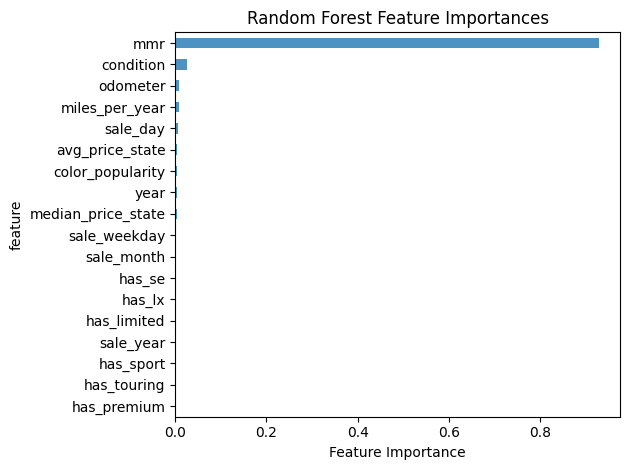

In [14]:
import matplotlib.pyplot as plt

# 7.2.1 Numerische Features definieren
numeric_features = cars_features_df.select_dtypes(include=[np.number]).drop("sellingprice", axis=1).columns.tolist()

# 7.2.2 Trainings- und Testdaten auswählen
X_train_num = X_train[numeric_features]
X_test_num  = X_test[numeric_features]
y_train_num = y_train
y_test_num  = y_test

# 7.2.3 RandomForest instanziieren und trainieren
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf.fit(X_train_num, y_train_num)

# 7.2.4 Vorhersagen für Trainings- und Test-Set
y_pred_train_rf = rf.predict(X_train_num)
y_pred_test_rf  = rf.predict(X_test_num)

# 7.2.5 Metriken berechnen
mae_train_rf, rmse_train_rf, r2_train_rf = calc_metrics(y_train_num, y_pred_train_rf)
mae_test_rf,  rmse_test_rf,  r2_test_rf  = calc_metrics(y_test_num,  y_pred_test_rf)

print(f"RF Train: MAE={mae_train_rf:.2f}, RMSE={rmse_train_rf:.2f}, R2={r2_train_rf:.4f}")
print(f"RF Test:  MAE={mae_test_rf:.2f}, RMSE={rmse_test_rf:.2f}, R2={r2_test_rf:.4f}")

# 7.2.6 Feature-Importances ableiten und visualisieren
importances = rf.feature_importances_
std         = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
features    = numeric_features

# DataFrame erstellen und sortieren
df_fi = pd.DataFrame({
    "feature": features,
    "importance": importances,
    "std": std
}).sort_values("importance")

# Barplot der wichtigsten Features
plt.figure(figsize=(8, 12))
df_fi.plot(
    kind="barh",
    x="feature",
    y="importance",
    legend=False,
    alpha=0.8
)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

## Interpretation der Ergebnisse

| Modell              | Set    | MAE    | RMSE   | R²      |
|---------------------|--------|--------|--------|---------|
| **Linear Regression**   | Train  | 887.85 | 1301.62 | 0.9318  |
|                     | Test   | 893.45 | 1306.29 | 0.9322  |
| **Random Forest**       | Train  | 288.16 |  423.44 | 0.9928  |
|                     | Test   | 778.56 | 1141.82 | 0.9482  |

- **Linear Regression**  
  - Die Performance auf Training und Test ist nahezu identisch (ΔRMSE ≈ 4.7), R² sogar leicht besser auf dem Test-Set.  
  - Das spricht für ein gut generalisierendes, aber insgesamt weniger flexibles Modell (R² ≈ 0.93).

- **Random Forest**  
  - Extrem niedriger Fehler auf dem Training-Set (RMSE=423, R²≈0.993) bei deutlich höherem Fehler im Test-Set (RMSE=1142, R²≈0.948).  
  - **Großes Overfitting**: Der Random Forest passt die Trainingsdaten sehr genau an, generalisiert aber nicht vollständig auf neue Beispiele.


## Plan zur Verbesserung des Datensatzes

1. **Prüfung auf Datenlecks**  
   - Temporären Ausschluss von `mmr`, um zu beurteilen, wie stark dieses Feature das Modell dominiert  
   - Kontrolle, ob andere Features indirekte Zielinformationen enthalten  

2. **Ausreißer erkennen und behandeln**  
   - Univariate Analyse (Boxplots, Z-Scores) für `sellingprice`, `odometer` und `miles_per_year`  
   - Entfernen oder Winsorisieren extremer Werte außerhalb des 1,5 × IQR-Bereichs  

3. **Verteilungstransformationen**  
   - Log-Transform für schief verteilte Merkmale (z. B. `odometer`, `sellingprice`)  
   - Normalitätsprüfung (Shapiro-Wilk, QQ-Plot) vor und nach Transformation  

4. **Neue Interaktions- und Polynom-Features**  
   - Produkt aus `year` und `miles_per_year` als Hinweis auf Intensivnutzung  
   - Quadratische Terme (z. B. `condition²`) für nicht-lineare Effekte  

5. **Feature-Selektion**  
   - Korrelationsmatrix erstellen und stark korrelierende Paare (|r| > 0.8) identifizieren  
   - Entfernen redundanter Merkmale oder Zusammenfassung zu Hauptkomponentenelementen (PCA)  

6. **Encoder-Alternativen für kategoriale Daten**  
   - Target-Encoding für seltene Kategorien (z. B. `body`, `transmission`)  
   - Prüfung, ob One-Hot-Encoding weiterer Features die Dimensionalität reduziert  

7. **Zeitliche und räumliche Kontextmerkmale**  
   - Einfache Saisonindikatoren (Winter/Sommer) statt numerischer Monatsvariable  
   - Regionale Cluster-Erstellung (z. B. Bundesstaat-Gruppen) für `avg_price_state`  

**Verbesserungen werden in einem separaten Notebook umgesetzt**  
